In [1]:
#Third stage. Apply the CC & CACK kernels to CLARA-based WSA to derive deltaCrRF. 

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pyresample
import dask.array as da
import pandas as pd
from tqdm.notebook import trange, tqdm
import gc

datadriveletter = 'Z:'
prod_data_dir = datadriveletter + '/radiative_forcing_2020/production_data/'
startyear = 1982
stopyear = 2018

NH_months = [3,4,5,6,7,8]
SH_months = [1,2,3,10,11,12]

In [2]:
WSA_EASE2_all_NH = xr.open_dataarray(prod_data_dir + '/C2_SAL_WSA_all_NH_1982_2018.nc')
WSA_EASE2_all_SH = xr.open_dataarray(prod_data_dir + '/C2_SAL_WSA_all_SH_1982_2018_v3.nc')

In [3]:
OSA_NH = xr.open_dataarray(prod_data_dir + 'OSA_EASE2_NH_1979_2019_gapfilled.nc').sel(time=slice(str(startyear), str(stopyear)))
OSA_SH = xr.open_dataarray(prod_data_dir + 'OSA_EASE2_SH_1979_2019_gapfilled.nc').sel(time=slice(str(startyear), str(stopyear)))


In [4]:
WSA_EASE2_all_SH

<xarray.DataArray (time: 444, lat: 720, lon: 720)>
[230169600 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2018-12-01
    latitude   (lat, lon) float64 ...
    longitude  (lat, lon) float64 ...
    month      (time) int64 ...
Dimensions without coordinates: lat, lon

In [5]:
WSA_EASE2_nobs_NH = xr.open_dataarray(prod_data_dir + 'SAL_NOBS_NH_full_extended.nc')
WSA_EASE2_nobs_SH = xr.open_dataarray(prod_data_dir + 'SAL_NOBS_SH_full_extended.nc')


In [6]:
#NH snow cover from NSIDC0046. See below for SH treatment (no seasonal snow)
snowicecover_NH = xr.open_dataarray(prod_data_dir + 'NSIDC0046_snowicecover_MM_at_EASE2NH_1982_2018.nc')
snowicecover_NH = snowicecover_NH.transpose('time','lat','lon')

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
snowicecover_SH = xr.open_dataarray(prod_data_dir + '/G02202_Antarctic_seaice_full_1978_2018_v2.nc').sel(time=slice(str(startyear), str(stopyear)))

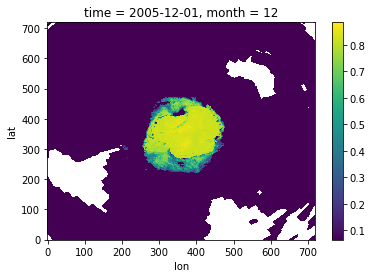

In [8]:
WSA_EASE2_all_SH.sel(time='2005-12-01').plot()

In [9]:
#now place OSA everywhere with open water on NH
WSA_EASE2_all_NH = xr.where(snowicecover_NH<250, WSA_EASE2_all_NH, OSA_NH)

#SH already filled
#WSA_EASE2_all_SH = xr.where(snowicecover_SH!=0, WSA_EASE2_all_SH, OSA_SH)

In [10]:
baseline_82_91_NH = WSA_EASE2_all_NH.sel(time=slice('1982','1991'))
baseline_82_91_NH = baseline_82_91_NH.groupby(baseline_82_91_NH.time.dt.month).mean('time').compute()

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [11]:
baseline_82_91_SH = WSA_EASE2_all_SH.sel(time=slice('1982','1991'))
baseline_82_91_SH = baseline_82_91_SH.groupby(baseline_82_91_SH.time.dt.month).mean('time').compute()

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


In [12]:
#amend the snowicecover to ensure that sea ice coverage and WSA magnitudes match (as OSI450 was the SAL sea ice basis)
snowicecover_NH = xr.where(((snowicecover_NH>5) & (WSA_EASE2_all_NH>0.12)), 3, snowicecover_NH)

#not necessary for SH
#snowicecover_SH = xr.where(((snowicecover_SH==0) & (WSA_EASE2_all_SH>0.12)), 0.05, snowicecover_SH)

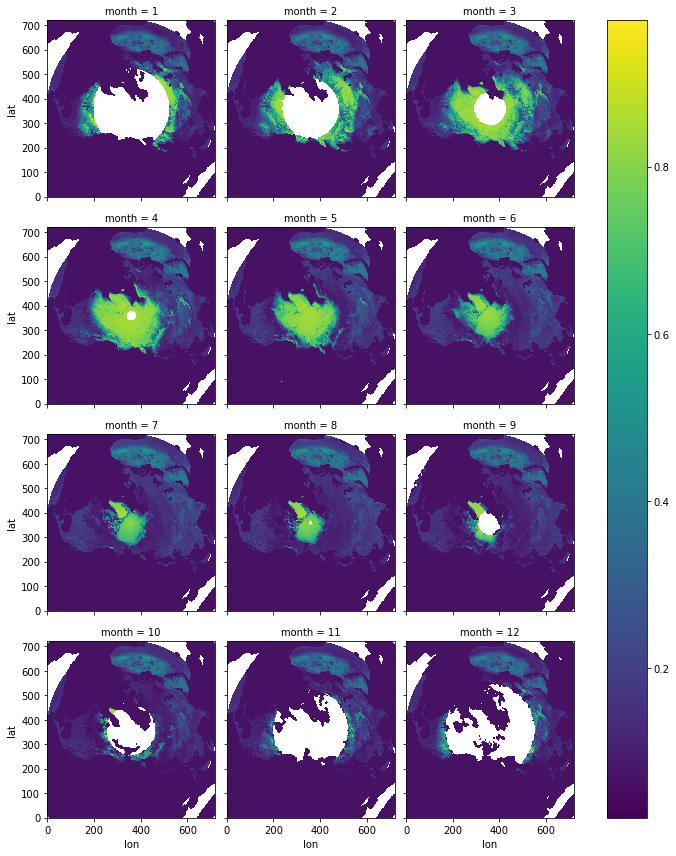

In [13]:
baseline_82_91_NH.plot(x='lon', y='lat', col='month', col_wrap=3)

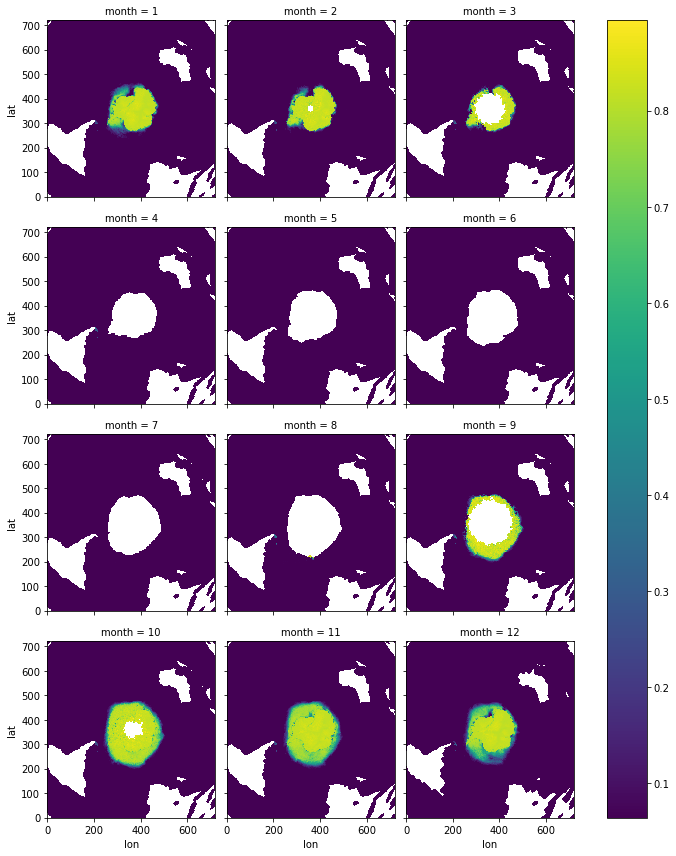

In [14]:
baseline_82_91_SH.plot(x='lon', y='lat', col='month', col_wrap=3)

In [15]:
#load kernels
CC_ALB_KERNEL_EASE2_NH_xr= xr.open_dataarray(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CC_NH.nc')
CC_ALB_KERNEL_EASE2_SH_xr = xr.open_dataarray(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CC_SH.nc')

CACK_ALB_KERNEL_EASE2_NH_xr = xr.open_dataarray(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CACK_extended_climatology_bf_fill_NH.nc')
CACK_ALB_KERNEL_EASE2_SH_xr = xr.open_dataarray(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CACK_extended_climatology_bf_fill_SH.nc')

#CACK comes with resolved uncertainty
CACK_UNCERT_ALB_KERNEL_EASE2_NH_xr = xr.open_dataarray(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CACK_UNCERT_extended_climatology_bf_fill_NH.nc')
CACK_UNCERT_ALB_KERNEL_EASE2_SH_xr = xr.open_dataarray(datadriveletter+'/EASE2_reprojected/TOA_RF_kernel_for_ALBEDO_CACK_UNCERT_extended_climatology_bf_fill_SH.nc')

In [16]:
CACK_ALB_KERNEL_EASE2_NH_xr

<xarray.DataArray (time: 444, lat: 720, lon: 720)>
[230169600 values with dtype=float64]
Coordinates:
    latitude   (lat, lon) float64 ...
    longitude  (lat, lon) float64 ...
  * time       (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2018-12-01
Dimensions without coordinates: lat, lon

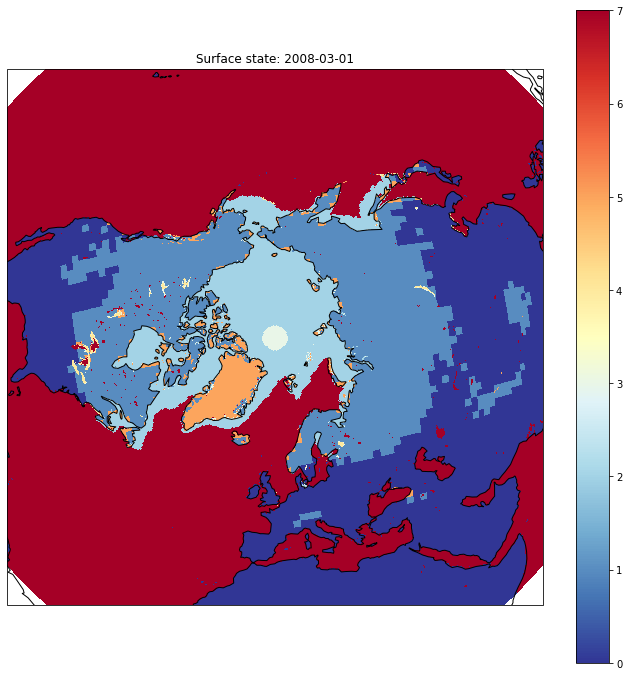

In [97]:
time_select='2008-03-01'
plt.figure(figsize=(12,12))
cmap3 = plt.get_cmap('RdYlBu_r')
#cmap2 = cmap.set_over('black')
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=90))
plt.pcolormesh(snowicecover_NH['longitude'], snowicecover_NH['latitude'], \
                snowicecover_NH.sel(time=time_select), transform=ccrs.PlateCarree(), vmin=0, vmax=7, cmap=cmap3)
ax.coastlines()
plt.colorbar()
plt.title('Surface state: '+time_select)
ax.set_extent((-180,180,25,90), crs=ccrs.PlateCarree())
plt.show()

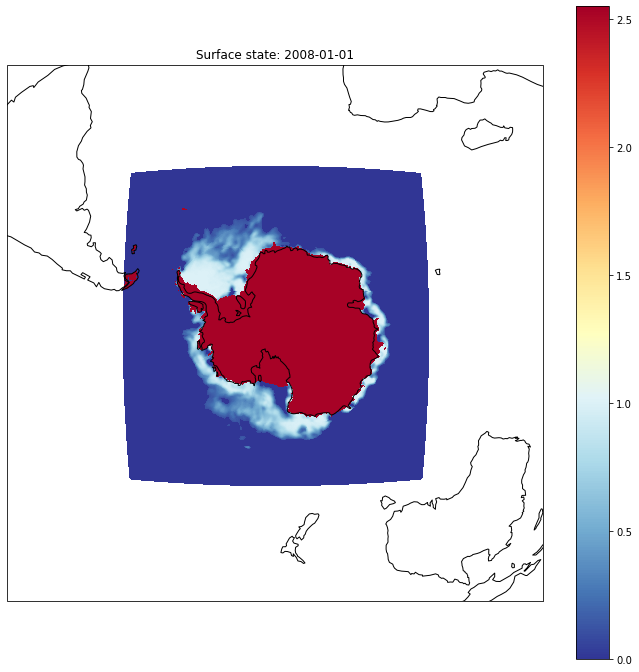

In [98]:
time_select='2008-01-01'
plt.figure(figsize=(12,12))
cmap3 = plt.get_cmap('RdYlBu_r')
#cmap2 = cmap.set_over('black')
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(snowicecover_SH['longitude'], snowicecover_SH['latitude'], \
                snowicecover_SH.sel(time=time_select), transform=ccrs.PlateCarree(), vmax=2.55, vmin=0, cmap=cmap3)
ax.coastlines()
plt.colorbar()
plt.title('Surface state: '+time_select)
ax.set_extent((-180,180,-25,-90), crs=ccrs.PlateCarree())
plt.show()

In [99]:
# prep for surface state change calculations
statechange = {'SNOW_TO_NOSNOW':1,\
              'NOSNOW_TO_SNOW':2,\
              'SEAICE_TO_WATER':3,\
              'WATER_TO_SEAICE':4,\
              'SNOW':5,\
              'LAND':6,\
              'SEAICE':7,\
              'WATER':8}

def mode(data, axis=0):
    from  scipy.stats import mode
    return mode(data, axis=axis)[0].squeeze()

baseline_snowcover_82_91_NH = snowicecover_NH.sel(time=slice('1982','1991')).groupby('time.month').reduce(mode, dim='time')
baseline_snowcover_82_91_SH = snowicecover_SH.sel(time=slice('1982','1991')).groupby('time.month').reduce(mode, dim='time')

C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\xarray\core\common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


In [16]:
# old version of amend baseline snowcover so that sea ice albedo and ice coverage match up - see above for new
#baseline_snowcover_82_91_NH = xr.where((baseline_snowcover_82_91_NH==255) & (baseline_82_91_NH>0.07), 2, baseline_snowcover_82_91_NH)
#baseline_snowcover_82_91_SH = xr.where((baseline_snowcover_82_91_SH==255) & (baseline_82_91_SH>0.07), 2, baseline_snowcover_82_91_SH)

In [103]:
# calculate spatially resolved changes in surface state / NH
# only include months where we have a measurable signal/change
import copy
'''
NH snow/sea ice classes
Data Value 	Parameter
0 	Snow-free land
1 	Snow-covered land
2 	Sea ice
3 	QC sea ice: pixel set to sea ice via QC during regridding
4 	QC ocean: pixel set to open ocean via QC during regridding
5 	QC snow: pixel set to snow via QC during regridding
6-252 	Not used
253 	Unclassifiable water due to mask mismatches
254 	Corner pixels (outside Northern Hemisphere)
255 	Open ocean
'''

alteredstate_NH = snowicecover_NH.copy().chunk((1,720,720)) * np.nan

for thisdt in tqdm(snowicecover_NH.time):
    if thisdt.dt.month not in NH_months:
        continue
    #print(thisdt.values)

    this_snowcover = snowicecover_NH.sel(time=thisdt)
    this_WSA = WSA_EASE2_all_NH.sel(time=thisdt)
    this_baseline_snowcover = baseline_snowcover_82_91_NH.sel(month=thisdt.dt.month)

    #diffstate = this_snowcover - this_baseline_snowcover
    #diffalb = this_WSA - baseline_82_91_NH.sel(month=thisdt.dt.month)
    alteredstate_this = this_snowcover.copy() * np.nan

    #initialize
    alteredstate_this = xr.where(this_snowcover==0, statechange['LAND'], alteredstate_this)
    alteredstate_this = xr.where((this_snowcover==1) | (this_snowcover==5), statechange['SNOW'], alteredstate_this)
    alteredstate_this = xr.where((this_snowcover==2) | (this_snowcover==3), statechange['SEAICE'], alteredstate_this)
    alteredstate_this = xr.where(this_snowcover==255, statechange['WATER'], alteredstate_this)


    #mark changes
    alteredstate_this = xr.where(((this_baseline_snowcover==2) | (this_baseline_snowcover==3)) \
                                      & (this_snowcover==255), statechange['SEAICE_TO_WATER'], alteredstate_this)
    alteredstate_this = xr.where(((this_snowcover==2) | (this_snowcover==3)) \
                                      & (this_baseline_snowcover==255), statechange['WATER_TO_SEAICE'], alteredstate_this)
    alteredstate_this = xr.where(((this_baseline_snowcover==1) | (this_baseline_snowcover==5)) \
                                      & (this_snowcover==0), statechange['SNOW_TO_NOSNOW'], alteredstate_this)
    alteredstate_this = xr.where(((this_snowcover==1) | (this_snowcover==5)) \
                                      & (this_baseline_snowcover==0), statechange['NOSNOW_TO_SNOW'], alteredstate_this)

    alteredstate_NH = xr.where(alteredstate_NH.time==thisdt, alteredstate_this, alteredstate_NH)

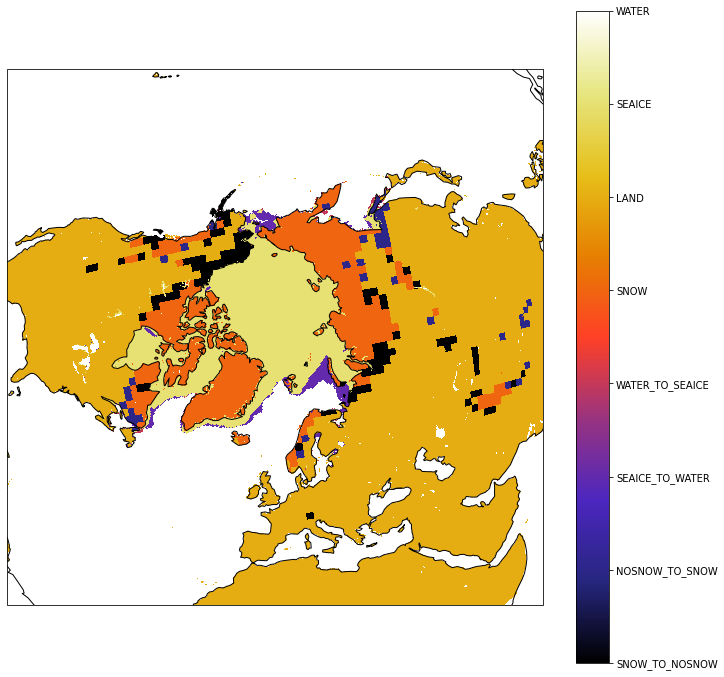

In [104]:
plt.figure(figsize=(12,12))
cmap_change = plt.get_cmap('CMRmap')
#cmap2 = cmap.set_over('black')
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=90))
plt.pcolormesh(snowicecover_NH['longitude'], snowicecover_NH['latitude'], \
                alteredstate_NH.sel(time='2015-05-01'), transform=ccrs.PlateCarree(), cmap=cmap_change)
ax.coastlines()

cbticks = np.arange(1,len(statechange)+1)
cblabels = [list(statechange.keys())[list(statechange.values()).index(x)] for x in np.arange(1,len(statechange)+1)]

cb = plt.colorbar()
cb.set_ticks(cbticks)
cb.set_ticklabels(cblabels)
ax.set_extent((-180,180,25,90), crs=ccrs.PlateCarree())
plt.show()

In [105]:
alteredstate_NH.to_netcdf(prod_data_dir + 'Surfacechange_NH_1982_2018_amendedseaice_v2.nc')

In [107]:
# calculate spatially resolved changes in surface state / SH
# only include months where we have a measurable signal/changeimport copy
import os.path
'''
Data Value 	Parameter
0 	Snow-free land
1 	Snow-covered land
2 	Sea ice
3 	QC sea ice: pixel set to sea ice via QC during regridding
4 	QC ocean: pixel set to open ocean via QC during regridding
5 	QC snow: pixel set to snow via QC during regridding
6-252 	Not used
253 	Unclassifiable water due to mask mismatches
254 	Corner pixels (outside Northern Hemisphere)
255 	Open ocean
'''


alteredstate_SH = snowicecover_SH.chunk((2,720,720)).copy() * np.nan

for thisdt in tqdm(snowicecover_SH.time):
    if thisdt.dt.month not in SH_months:
        continue    
    
    this_snowcover = snowicecover_SH.sel(time=thisdt)
    this_WSA = WSA_EASE2_all_SH.sel(time=thisdt)
    this_baseline_snowcover = baseline_snowcover_82_91_SH.sel(month=thisdt.time.dt.month)


    #diffstate = this_snowcover - this_baseline_snowcover
    #diffalb = this_WSA - baseline_82_91_SH.sel(month=thisdt.time.dt.month)

    alteredstate_this = this_snowcover.copy() * np.nan
    alteredstate_this = xr.where((this_snowcover>2.5), statechange['SNOW'], alteredstate_this)
    alteredstate_this = xr.where((this_snowcover>0) & (this_snowcover<=1.0), statechange['SEAICE'], \
                                 alteredstate_this)
    alteredstate_this = xr.where(this_snowcover==0.0, statechange['WATER'], alteredstate_this)


    #mark changes
    alteredstate_this = xr.where(((this_baseline_snowcover>0) & (this_baseline_snowcover<=1.0)) \
                                      & (this_snowcover==0.0), statechange['SEAICE_TO_WATER'], alteredstate_this)
    alteredstate_this = xr.where(((this_snowcover>0) & (this_snowcover<=1.0)) \
                                      & (this_baseline_snowcover==0.0), statechange['WATER_TO_SEAICE'], alteredstate_this)
    alteredstate_this = xr.where((this_baseline_snowcover>2.5) \
                                      & (this_snowcover<2.5), statechange['SNOW_TO_NOSNOW'], alteredstate_this)
    alteredstate_this = xr.where((this_snowcover>2.5) \
                                      & (this_baseline_snowcover<2.5), statechange['NOSNOW_TO_SNOW'], alteredstate_this)

    alteredstate_SH = xr.where(alteredstate_SH.time==thisdt, alteredstate_this, alteredstate_SH)

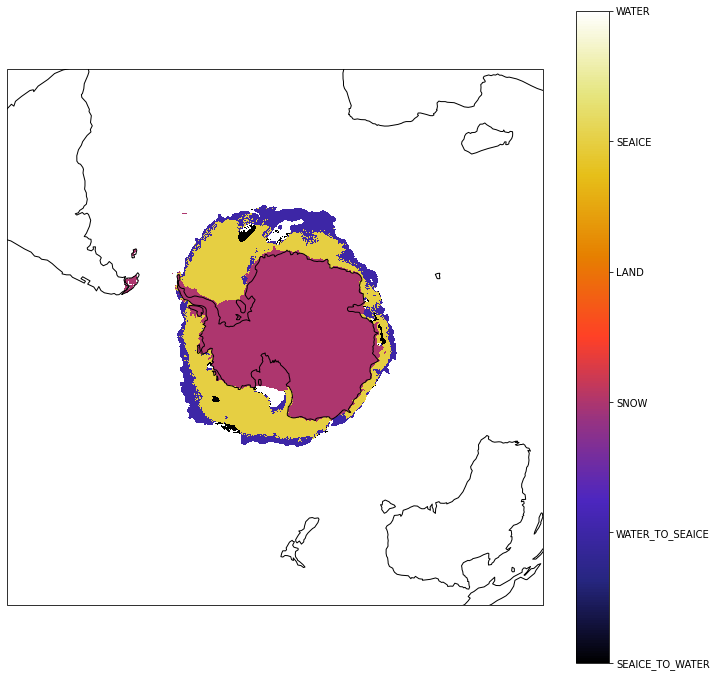

In [108]:
plt.figure(figsize=(12,12))
cmap_change = plt.get_cmap('CMRmap')
#cmap2 = cmap.set_over('black')
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(snowicecover_SH['longitude'], snowicecover_SH['latitude'], \
                alteredstate_SH.sel(time='2018-12-01'), transform=ccrs.PlateCarree(), cmap=cmap_change)
ax.coastlines()

cbticks = np.arange(1,len(statechange)+1)
cblabels = [list(statechange.keys())[list(statechange.values()).index(x)] for x in np.arange(1,len(statechange)+1)]

cb = plt.colorbar()
cb.set_ticks(cbticks)
cb.set_ticklabels(cblabels)
ax.set_extent((-180,180,-25,-90), crs=ccrs.PlateCarree())
plt.show()

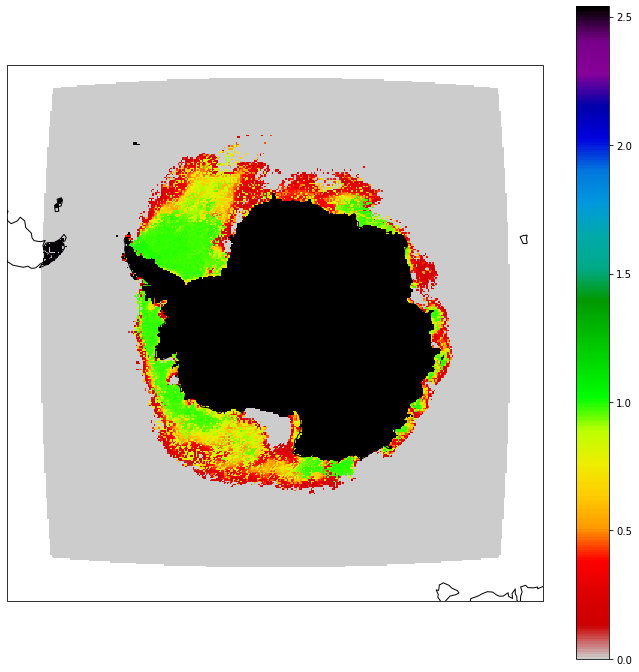

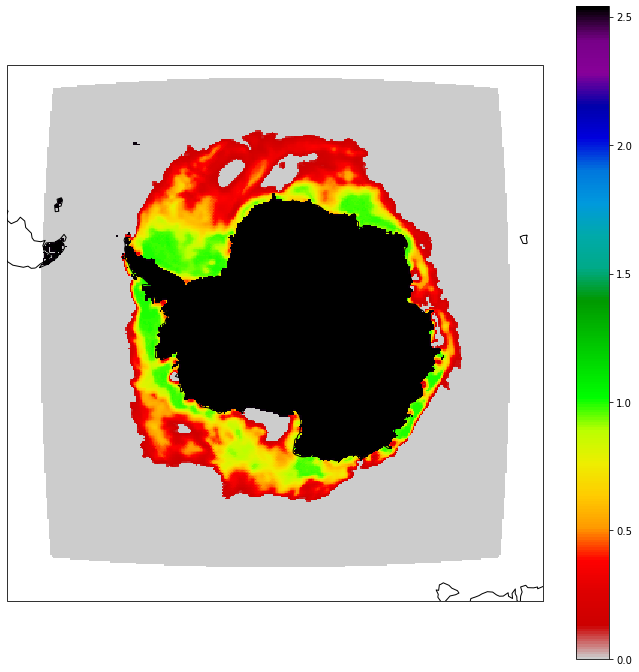

In [109]:
plt.figure(figsize=(12,12))
cmap_change = plt.get_cmap('nipy_spectral_r')
#cmap2 = cmap.set_over('black')
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(snowicecover_SH['longitude'], snowicecover_SH['latitude'], \
                baseline_snowcover_82_91_SH.sel(month=12), transform=ccrs.PlateCarree(), cmap=cmap_change)
ax.coastlines()

#cbticks = np.arange(1,len(statechange)+1)
#cblabels = [list(statechange.keys())[list(statechange.values()).index(x)] for x in np.arange(1,len(statechange)+1)]

cb = plt.colorbar()
#cb.set_ticks(cbticks)
#cb.set_ticklabels(cblabels)
ax.set_extent((-180,180,-49,-90), crs=ccrs.PlateCarree())
plt.show()

plt.figure(figsize=(12,12))
cmap_change = plt.get_cmap('nipy_spectral_r')
#cmap2 = cmap.set_over('black')
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(snowicecover_SH['longitude'], snowicecover_SH['latitude'], \
                snowicecover_SH.sel(time='2018-12-01'), transform=ccrs.PlateCarree(), cmap=cmap_change)
ax.coastlines()

#cbticks = np.arange(1,len(statechange)+1)
#cblabels = [list(statechange.keys())[list(statechange.values()).index(x)] for x in np.arange(1,len(statechange)+1)]

cb = plt.colorbar()
#cb.set_ticks(cbticks)
#cb.set_ticklabels(cblabels)
ax.set_extent((-180,180,-49,-90), crs=ccrs.PlateCarree())
plt.show()

In [110]:
alteredstate_SH.to_netcdf(prod_data_dir + 'Surfacechange_SH_1982_2018_amendedseaice_v2.nc')

## Now calculate all forcings, both hemispheres, both kernels, with NOBS-based uncertainty estimates per grid cell

In [67]:
def get_uncert(data):
    nobs_for_small_error = 375 # 5x5 samples in a grid cell, 15 days in a month -> 375 samples for decent coverage (first guess)
    nobs_for_largest_error = 50

    rel_uncert_min = 0.025
    rel_uncert_max = 0.075

    uncert_slope = (rel_uncert_max-rel_uncert_min)/(nobs_for_largest_error-nobs_for_small_error)
    #print(uncert_slope)
    
    UC = data.copy()
    UC = (data-nobs_for_largest_error)*uncert_slope + rel_uncert_max
    UC = UC.where(data>nobs_for_largest_error, rel_uncert_max)
    UC = UC.where(data<nobs_for_small_error, rel_uncert_min)
    
    #UC_multiplier = np.random.uniform(0, 1, UC.shape)
    UC_multiplier = np.random.beta(2,3, UC.shape)
    
    return UC * UC_multiplier

In [112]:

perturbation_count = 3
noise_type = 'nobs_limit' #'uniform' #'normal'
baseline_noise = False
kernel_noise_max = 0.25

#try:
#    radiative_forcing_CLARAWSA_NH
#    del radiative_forcing_CLARAWSA_NH
#except NameError:
#    print('Creating new result xr')

cmap3 = plt.get_cmap('RdYlBu_r')
radiative_forcing_CLARAWSA_CC_NH = WSA_EASE2_all_NH.copy(deep=True) * np.nan
radiative_forcing_CLARAWSA_CC_NH = radiative_forcing_CLARAWSA_CC_NH.expand_dims({'perturbation':perturbation_count}, axis=0).copy()

radiative_forcing_CLARAWSA_CACK_NH = WSA_EASE2_all_NH.copy(deep=True) * np.nan
radiative_forcing_CLARAWSA_CACK_NH = radiative_forcing_CLARAWSA_CACK_NH.expand_dims({'perturbation':perturbation_count}, axis=0).copy()

print('Initiate forcing calculation.')
for ptb in np.arange(0,perturbation_count):
    print('Perturbation: '+str(ptb))
    print('*************')
    for tdt in tqdm(WSA_EASE2_all_NH.time):
        mn = tdt.time.dt.month.values
        #print(tdt.time.values)
        thisWSA = WSA_EASE2_all_NH.where(WSA_EASE2_all_NH.time == tdt, drop=True)
        if noise_type=='normal': # This is the normal-distributed noise perturbation. Essentially coalesces down to the effect of the distribution center location
            noise_up = np.random.normal(0.05, 0.1, thisWSA.shape)
            noise_dn = np.random.normal(-0.05, 0.1, thisWSA.shape)
            if ptb == 0:
                thisWSA_perturbed = thisWSA 
            elif ptb<np.ceil(perturbation_count/2):
                thisWSA_perturbed = thisWSA + (thisWSA * noise_dn)
            else:
                thisWSA_perturbed = thisWSA + (thisWSA * noise_up)

        #This is the uniform random draw noise in both albedo and kernel
        if noise_type=='uniform':
            noise = np.random.uniform(-0.1, 0.1, thisWSA.shape)
            thisWSA_perturbed = thisWSA + (thisWSA * noise)

        if noise_type=='nobs_limit':
            if ptb == 0:
                thisWSA_perturbed = thisWSA 
            elif ptb<np.ceil(perturbation_count/2):
                noise_dn = -1 * get_uncert(thisWSA) #negative beta noise
                thisWSA_perturbed = thisWSA + (thisWSA * noise_dn)
            else:
                noise_up = get_uncert(thisWSA) #random beta-distribution value from 0 to pix uncert, positive
                thisWSA_perturbed = thisWSA + (thisWSA * noise_up)

        nans = xr.ufuncs.isnan(thisWSA_perturbed)
        thisWSA_perturbed = xr.where(thisWSA_perturbed<1.0, thisWSA_perturbed, 0.95)
        thisWSA_perturbed = xr.where(thisWSA_perturbed>0.0, thisWSA_perturbed, 0.02)
        thisWSA_perturbed = xr.where(nans, np.nan, thisWSA_perturbed)

        if baseline_noise:
            noise_bl = np.random.uniform(-0.1, 0.1, baseline_82_91_NH.sel(month=tdt.dt.month).shape)
            diff = thisWSA_perturbed - (baseline_82_91_NH.sel(month=tdt.dt.month) + 
                                        (noise_bl * baseline_82_91_NH.sel(month=tdt.dt.month)))
        else:
            diff = thisWSA_perturbed - baseline_82_91_NH.sel(month=tdt.dt.month)

        for kernel in ['CC', 'CACK']:
            if kernel=='CACK':
                thiskernel = CACK_ALB_KERNEL_EASE2_NH_xr.sel(time=tdt)
                kernel_noise = CACK_UNCERT_ALB_KERNEL_EASE2_NH_xr.sel(time=tdt)
                thiskernel_perturbed = thiskernel + kernel_noise
            else:
                thiskernel = CC_ALB_KERNEL_EASE2_NH_xr.sel(time=tdt.dt.month)
                kernel_noise = np.random.uniform(-1*kernel_noise_max, kernel_noise_max, np.squeeze(thiskernel.shape))
                thiskernel_perturbed = thiskernel + (kernel_noise * thiskernel)

            if ptb==0:
                thiskernel_perturbed = thiskernel

            #print('Data load complete. Calculate Forcing.')
            if kernel=='CACK':
                CACK_radiative_forcing_tmp = (diff * -1 * thiskernel_perturbed)
                CACK_radiative_forcing_tmp.drop(['month'])
                radiative_forcing_CLARAWSA_CACK_NH.loc[dict(perturbation=ptb, time=tdt)] =  np.squeeze(CACK_radiative_forcing_tmp.values)
            else:
                CC_radiative_forcing_tmp = (diff/0.01 * thiskernel_perturbed)
                CC_radiative_forcing_tmp.drop(['month'])
                radiative_forcing_CLARAWSA_CC_NH.loc[dict(perturbation=ptb, time=tdt)] =  np.squeeze(CC_radiative_forcing_tmp.values)

            #print('Forcing calculated.')
            gc.collect()

Initiate forcing calculation.
Perturbation: 0
*************



Perturbation: 1
*************



Perturbation: 2
*************


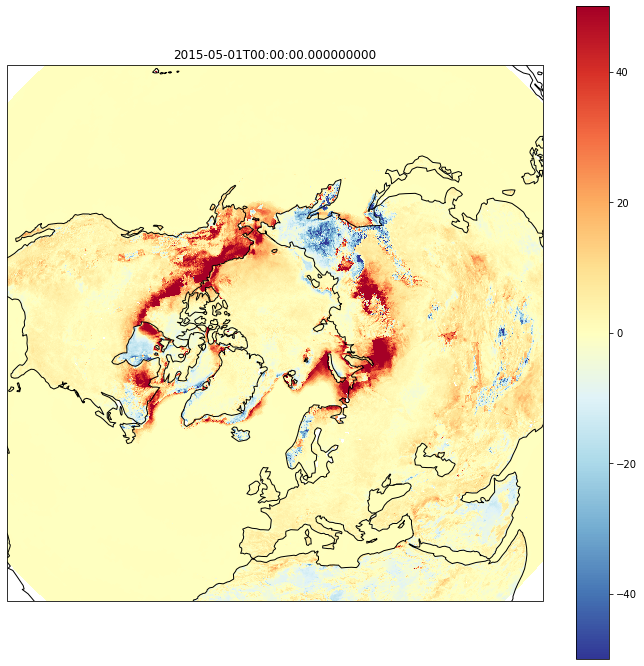

In [113]:
plt.figure(figsize=(12,12))
cmap_change = plt.get_cmap('RdYlBu_r')
#cmap2 = cmap.set_over('black')
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=90))
plt.pcolormesh(snowicecover_NH['longitude'], snowicecover_NH['latitude'], \
                radiative_forcing_CLARAWSA_CACK_NH.sel(dict(perturbation=0,time='2015-05-01')), \
               transform=ccrs.PlateCarree(), cmap=cmap_change, vmin=-50, vmax=50)
ax.coastlines()


#cbticks = np.arange(1,len(statechange)+1)
#cblabels = [list(statechange.keys())[list(statechange.values()).index(x)] for x in np.arange(1,len(statechange)+1)]

cb = plt.colorbar()
#cb.set_ticks(cbticks)
#cb.set_ticklabels(cblabels)
ax.set_extent((-180,180,25,90), crs=ccrs.PlateCarree())
plt.title(radiative_forcing_CLARAWSA_CACK_NH.sel(dict(perturbation=0,time='2015-05-01')).time.values)
plt.show()

In [114]:
radiative_forcing_CLARAWSA_CACK_NH = radiative_forcing_CLARAWSA_CACK_NH.assign_coords({'latitude':snowicecover_NH.latitude, 'longitude':snowicecover_NH.longitude})
radiative_forcing_CLARAWSA_CC_NH = radiative_forcing_CLARAWSA_CC_NH.assign_coords({'latitude':snowicecover_NH.latitude, 'longitude':snowicecover_NH.longitude})


In [115]:
radiative_forcing_CLARAWSA_CACK_NH.to_netcdf(prod_data_dir + 'Radiative_forcing_C2WSA_CACK_NH_full_OSA_climat_bf_fill_v2.nc')
radiative_forcing_CLARAWSA_CC_NH.to_netcdf(prod_data_dir + 'Radiative_forcing_C2WSA_CC_NH_full_OSA_v2.nc')

In [116]:
#Now SH
perturbation_count = 3
noise_type = 'nobs_limit' #'uniform' #'normal'
baseline_noise = False
kernel_noise_max = 0.25

#try:
#    radiative_forcing_CLARAWSA_NH
#    del radiative_forcing_CLARAWSA_NH
#except NameError:
#    print('Creating new result xr')

cmap3 = plt.get_cmap('RdYlBu_r')
radiative_forcing_CLARAWSA_CC_SH = WSA_EASE2_all_SH.copy(deep=True) * np.nan
radiative_forcing_CLARAWSA_CC_SH = radiative_forcing_CLARAWSA_CC_SH.expand_dims({'perturbation':perturbation_count}, axis=0).copy()

radiative_forcing_CLARAWSA_CACK_SH = WSA_EASE2_all_SH.copy(deep=True) * np.nan
radiative_forcing_CLARAWSA_CACK_SH = radiative_forcing_CLARAWSA_CACK_SH.expand_dims({'perturbation':perturbation_count}, axis=0).copy()

for ptb in np.arange(0,perturbation_count):
    print('Calculate forcings, Perturbation: '+str(ptb))
    print('*************')
    for tdt in tqdm(WSA_EASE2_all_SH.time):
        mn = tdt.time.dt.month.values
        #print(tdt.time.values)
        thisWSA = WSA_EASE2_all_SH.where(WSA_EASE2_all_SH.time == tdt, drop=True)
        if noise_type=='normal': # This is the normal-distributed noise perturbation. Essentially coalesces down to the effect of the distribution center location
            noise_up = np.random.normal(0.05, 0.1, thisWSA.shape)
            noise_dn = np.random.normal(-0.05, 0.1, thisWSA.shape)
            if ptb == 0:
                thisWSA_perturbed = thisWSA 
            elif ptb<np.ceil(perturbation_count/2):
                thisWSA_perturbed = thisWSA + (thisWSA * noise_dn)
            else:
                thisWSA_perturbed = thisWSA + (thisWSA * noise_up)

        #This is the uniform random draw noise in both albedo and kernel
        if noise_type=='uniform':
            noise = np.random.uniform(-0.1, 0.1, thisWSA.shape)
            thisWSA_perturbed = thisWSA + (thisWSA * noise)

        if noise_type=='nobs_limit':
            if ptb == 0:
                thisWSA_perturbed = thisWSA 
            elif ptb<np.ceil(perturbation_count/2):
                noise_dn = -1 * get_uncert(thisWSA) #negative beta noise
                thisWSA_perturbed = thisWSA + (thisWSA * noise_dn)
            else:
                noise_up = get_uncert(thisWSA) #random beta-distribution value from 0 to pix uncert, positive
                thisWSA_perturbed = thisWSA + (thisWSA * noise_up)

        nans = xr.ufuncs.isnan(thisWSA_perturbed)
        thisWSA_perturbed = xr.where(thisWSA_perturbed<1.0, thisWSA_perturbed, 0.95)
        thisWSA_perturbed = xr.where(thisWSA_perturbed>0.0, thisWSA_perturbed, 0.02)
        thisWSA_perturbed = xr.where(nans, np.nan, thisWSA_perturbed)

        if baseline_noise:
            noise_bl = np.random.uniform(-0.1, 0.1, baseline_82_91_SH.sel(month=tdt.dt.month).shape)
            diff = thisWSA_perturbed - (baseline_82_91_SH.sel(month=tdt.dt.month) + 
                                        (noise_bl * baseline_82_91_SH.sel(month=tdt.dt.month)))
        else:
            diff = thisWSA_perturbed - baseline_82_91_SH.sel(month=tdt.dt.month)


        for kernel in ['CC', 'CACK']:
            if kernel=='CACK':
                thiskernel = CACK_ALB_KERNEL_EASE2_SH_xr.sel(time=tdt)
                kernel_noise = CACK_UNCERT_ALB_KERNEL_EASE2_SH_xr.sel(time=tdt)
                thiskernel_perturbed = thiskernel + kernel_noise
            else:
                thiskernel = CC_ALB_KERNEL_EASE2_SH_xr.sel(time=tdt.dt.month)
                kernel_noise = np.random.uniform(-1*kernel_noise_max, kernel_noise_max, np.squeeze(thiskernel.shape))
                thiskernel_perturbed = thiskernel + (kernel_noise * thiskernel)

            if ptb==0:
                thiskernel_perturbed = thiskernel

            #print('Data load complete. Calculate Forcing.')
            if kernel=='CACK':
                CACK_radiative_forcing_tmp = (diff * -1 * thiskernel_perturbed)
                CACK_radiative_forcing_tmp.drop(['month'])
                radiative_forcing_CLARAWSA_CACK_SH.loc[dict(perturbation=ptb, time=tdt)] =  np.squeeze(CACK_radiative_forcing_tmp.values)
            else:
                CC_radiative_forcing_tmp = (diff/0.01 * thiskernel_perturbed)
                CC_radiative_forcing_tmp.drop(['month'])
                radiative_forcing_CLARAWSA_CC_SH.loc[dict(perturbation=ptb, time=tdt)] =  np.squeeze(CC_radiative_forcing_tmp.values)

        #print('Forcing calculated.')
        gc.collect()

Calculate forcings, Perturbation: 0
*************



Calculate forcings, Perturbation: 1
*************



Calculate forcings, Perturbation: 2
*************


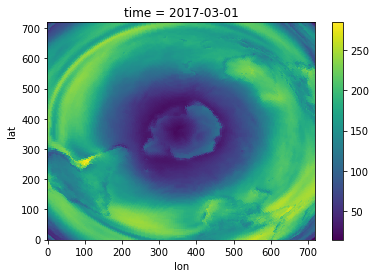

In [117]:
CACK_ALB_KERNEL_EASE2_SH_xr.sel(time='2017-03-01').plot()

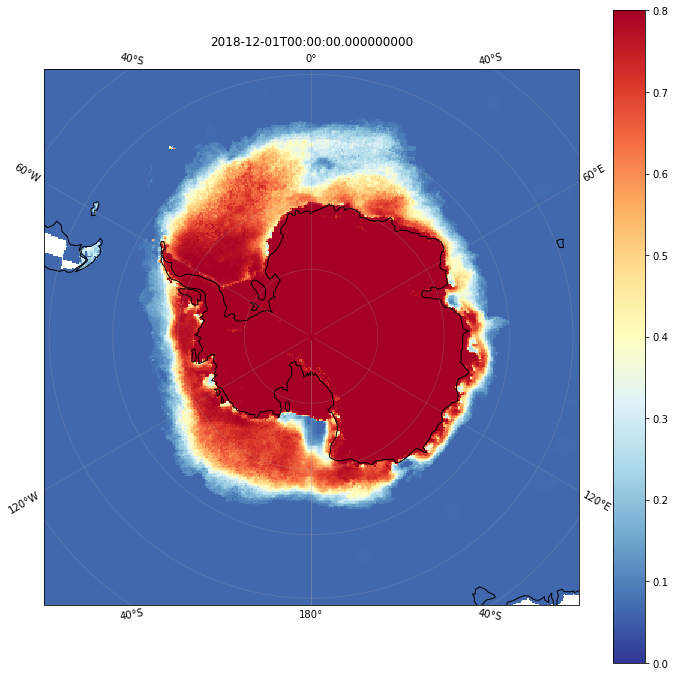

In [118]:
plt.figure(figsize=(12,12))
cmap_change = plt.get_cmap('RdYlBu_r')
#cmap2 = cmap.set_over('black')
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(snowicecover_SH['longitude'], snowicecover_SH['latitude'], \
                baseline_82_91_SH.sel(month=12), \
               transform=ccrs.PlateCarree(), cmap=cmap_change, vmin=0, vmax=.80)
ax.coastlines()
ax.gridlines(draw_labels=True, alpha=0.25)


#cbticks = np.arange(1,len(statechange)+1)
#cblabels = [list(statechange.keys())[list(statechange.values()).index(x)] for x in np.arange(1,len(statechange)+1)]

cb = plt.colorbar()
#cb.set_ticks(cbticks)
#cb.set_ticklabels(cblabels)
ax.set_extent((-180,180,-49,-90), crs=ccrs.PlateCarree())
plt.title(radiative_forcing_CLARAWSA_CACK_SH.sel(dict(perturbation=0,time='2018-12-01')).time.values)
plt.show()

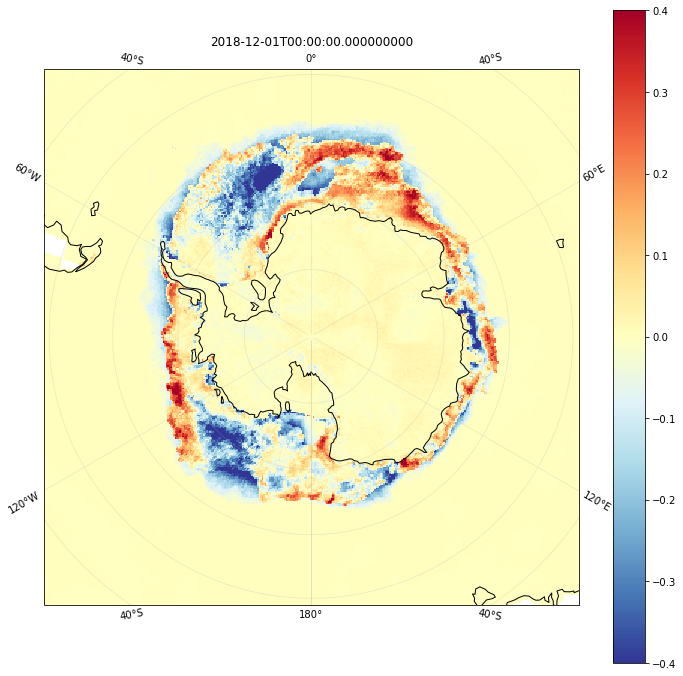

In [119]:
plt.figure(figsize=(12,12))
cmap_change = plt.get_cmap('RdYlBu_r')
#cmap2 = cmap.set_over('black')
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(snowicecover_SH['longitude'], snowicecover_SH['latitude'], \
                WSA_EASE2_all_SH.sel(time='2018-12-01')-baseline_82_91_SH.sel(month=12), \
               transform=ccrs.PlateCarree(), cmap=cmap_change, vmin=-0.4, vmax=.40)
ax.coastlines()
ax.gridlines(draw_labels=True, alpha=0.25)


#cbticks = np.arange(1,len(statechange)+1)
#cblabels = [list(statechange.keys())[list(statechange.values()).index(x)] for x in np.arange(1,len(statechange)+1)]

cb = plt.colorbar()
#cb.set_ticks(cbticks)
#cb.set_ticklabels(cblabels)
ax.set_extent((-180,180,-49,-90), crs=ccrs.PlateCarree())
plt.title(radiative_forcing_CLARAWSA_CACK_SH.sel(dict(perturbation=0,time='2018-12-01')).time.values)
plt.show()

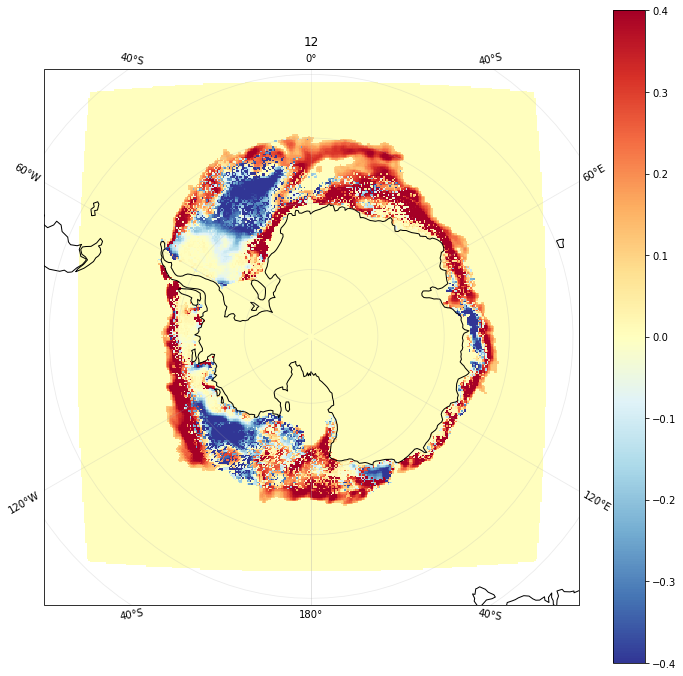

In [120]:
plt.figure(figsize=(12,12))
cmap_change = plt.get_cmap('RdYlBu_r')
#cmap2 = cmap.set_over('black')
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(snowicecover_SH['longitude'], snowicecover_SH['latitude'], \
                snowicecover_SH.sel(time='2018-12-01')-baseline_snowcover_82_91_SH.sel(month=12), \
               transform=ccrs.PlateCarree(), cmap=cmap_change, vmin=-.40, vmax=.40)
ax.coastlines()
ax.gridlines(draw_labels=True, alpha=0.25)


#cbticks = np.arange(1,len(statechange)+1)
#cblabels = [list(statechange.keys())[list(statechange.values()).index(x)] for x in np.arange(1,len(statechange)+1)]

cb = plt.colorbar()
#cb.set_ticks(cbticks)
#cb.set_ticklabels(cblabels)
ax.set_extent((-180,180,-49,-90), crs=ccrs.PlateCarree())
plt.title(baseline_82_91_SH.sel(month=12).month.values)
plt.show()

statechange = {'SNOW_TO_NOSNOW':1,\
              'NOSNOW_TO_SNOW':2,\
              'SEAICE_TO_WATER':3,\
              'WATER_TO_SEAICE':4,\
              'SNOW':5,\
              'LAND':6,\
              'SEAICE':7,\
              'WATER':8}

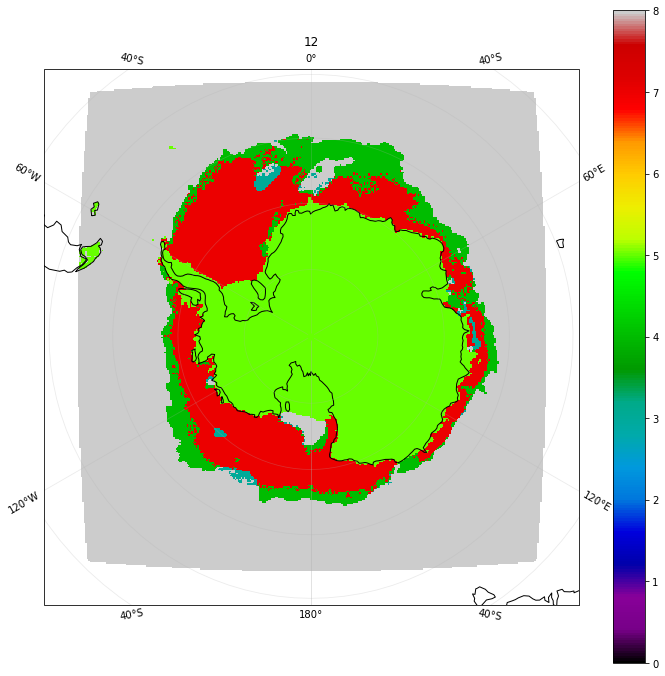

In [121]:
plt.figure(figsize=(12,12))
cmap_change = plt.get_cmap('nipy_spectral')
#cmap2 = cmap.set_over('black')
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(snowicecover_SH['longitude'], snowicecover_SH['latitude'], \
                alteredstate_SH.sel(time='2018-12-01'), \
               transform=ccrs.PlateCarree(), cmap=cmap_change, vmin=0, vmax=8)
ax.coastlines()
ax.gridlines(draw_labels=True, alpha=0.25)


#cbticks = np.arange(1,len(statechange)+1)
#cblabels = [list(statechange.keys())[list(statechange.values()).index(x)] for x in np.arange(1,len(statechange)+1)]

cb = plt.colorbar()
#cb.set_ticks(cbticks)
#cb.set_ticklabels(cblabels)
ax.set_extent((-180,180,-49,-90), crs=ccrs.PlateCarree())
plt.title(baseline_82_91_SH.sel(month=12).month.values)
plt.show()

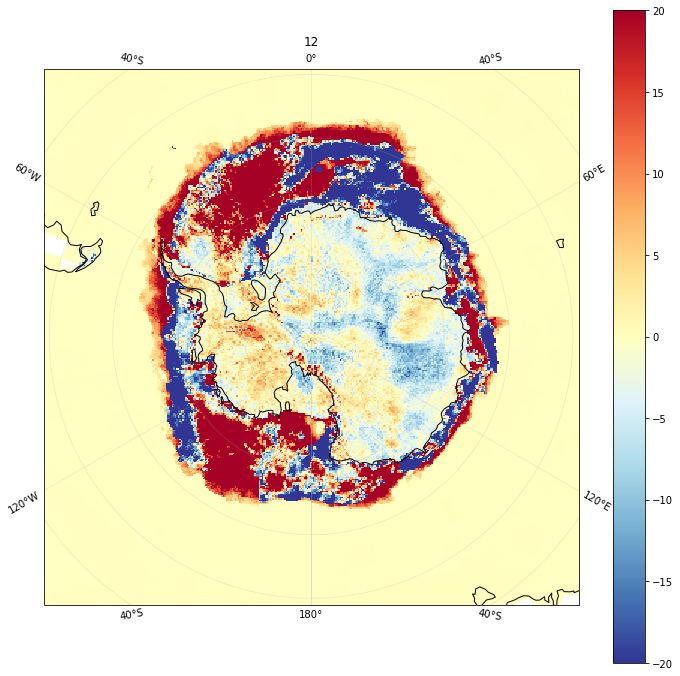

In [122]:
plt.figure(figsize=(12,12))
cmap_change = plt.get_cmap('RdYlBu_r')
#cmap2 = cmap.set_over('black')
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(snowicecover_SH['longitude'], snowicecover_SH['latitude'], \
                radiative_forcing_CLARAWSA_CC_SH.sel(time='2018-12-01', perturbation=0), \
               transform=ccrs.PlateCarree(), cmap=cmap_change, vmin=-20, vmax=20)
ax.coastlines()
ax.gridlines(draw_labels=True, alpha=0.25)


#cbticks = np.arange(1,len(statechange)+1)
#cblabels = [list(statechange.keys())[list(statechange.values()).index(x)] for x in np.arange(1,len(statechange)+1)]

cb = plt.colorbar()
#cb.set_ticks(cbticks)
#cb.set_ticklabels(cblabels)
ax.set_extent((-180,180,-49,-90), crs=ccrs.PlateCarree())
plt.title(baseline_82_91_SH.sel(month=12).month.values)
plt.show()

In [123]:
radiative_forcing_CLARAWSA_CACK_SH = radiative_forcing_CLARAWSA_CACK_SH.assign_coords({'latitude':snowicecover_SH.latitude, 'longitude':snowicecover_SH.longitude})
radiative_forcing_CLARAWSA_CC_SH = radiative_forcing_CLARAWSA_CC_SH.assign_coords({'latitude':snowicecover_SH.latitude, 'longitude':snowicecover_SH.longitude})


In [124]:
radiative_forcing_CLARAWSA_CACK_SH.to_netcdf(prod_data_dir + 'Radiative_forcing_C2WSA_CACK_OSA_SH_full_climat_bf_fill_v2.nc')
radiative_forcing_CLARAWSA_CC_SH.to_netcdf(prod_data_dir + 'Radiative_forcing_C2WSA_CC_OSA_SH_full_v2.nc')

<xarray.DataArray 'time' ()>
array('1997-12-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1997-12-01


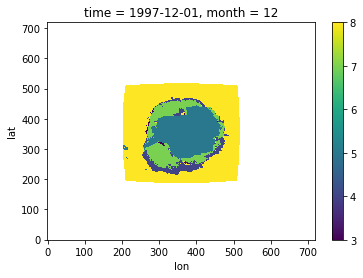

<xarray.DataArray 'time' ()>
array('1998-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1998-01-01


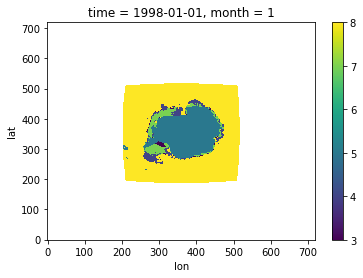

In [125]:
for thisdt in tqdm(snowicecover_SH.time[191:193]):
    if thisdt.dt.month not in SH_months:
        continue    
    print(thisdt)
    this_snowcover = snowicecover_SH.sel(time=thisdt)
    this_baseline_snowcover = baseline_snowcover_82_91_SH.sel(month=thisdt.time.dt.month)
    alteredstate_this = this_snowcover.copy() * np.nan
    alteredstate_this = xr.where((this_snowcover>2.5), statechange['SNOW'], alteredstate_this)
    alteredstate_this = xr.where((this_snowcover>0) & (this_snowcover<=1.0), statechange['SEAICE'], \
                                 alteredstate_this)
    alteredstate_this = xr.where(this_snowcover==0.0, statechange['WATER'], alteredstate_this)


    #mark changes
    alteredstate_this = xr.where(((this_baseline_snowcover>0) & (this_baseline_snowcover<=1.0)) \
                                      & (this_snowcover==0.0), statechange['SEAICE_TO_WATER'], alteredstate_this)
    alteredstate_this = xr.where(((this_snowcover>0) & (this_snowcover<=1.0)) \
                                      & (this_baseline_snowcover==0.0), statechange['WATER_TO_SEAICE'], alteredstate_this)
    alteredstate_this = xr.where((this_baseline_snowcover>2.5) \
                                      & (this_snowcover<2.5), statechange['SNOW_TO_NOSNOW'], alteredstate_this)
    alteredstate_this = xr.where((this_snowcover>2.5) \
                                      & (this_baseline_snowcover<2.5), statechange['NOSNOW_TO_SNOW'], alteredstate_this)

    alteredstate_this.plot()
    plt.show()
    #plt.figure(figsize=(14,7))
    #plt.subplot(121)
    #this_snowcover.plot()
    #plt.subplot(122)
    #this_baseline_snowcover.plot()
    #plt.show()

In [58]:
## Also calculate forcings with a CC-like version of CACK, i.e. months frm 2009 except Mar, Dec from 2008
CC_like_CACK_NH = CACK_ALB_KERNEL_EASE2_NH_xr.sel(time='2009').copy()

CC_like_CACK_NH.loc[dict(time='2009-03-01')] = CACK_ALB_KERNEL_EASE2_NH_xr.loc['2008-03-01'].values
CC_like_CACK_NH.loc[dict(time='2009-12-01')] = CACK_ALB_KERNEL_EASE2_NH_xr.loc['2008-12-01'].values
CC_like_CACK_NH = CC_like_CACK_NH.groupby(CC_like_CACK_NH.time.dt.month).mean()


CC_like_CACK_NH_full = [CC_like_CACK_NH.sel(month=x.dt.month) for x in CACK_ALB_KERNEL_EASE2_NH_xr.time]
CC_like_CACK_NH_full = xr.concat(CC_like_CACK_NH_full, 'time')
CC_like_CACK_NH_full['time'] = CACK_ALB_KERNEL_EASE2_NH_xr.time


In [68]:
perturbation_count = 3
noise_type = 'nobs_limit' #'uniform' #'normal'
baseline_noise = False
kernel_noise_max = 0.25

#try:
#    radiative_forcing_CLARAWSA_NH
#    del radiative_forcing_CLARAWSA_NH
#except NameError:
#    print('Creating new result xr')

cmap3 = plt.get_cmap('RdYlBu_r')
radiative_forcing_CLARAWSA_CC_NH = WSA_EASE2_all_NH.copy(deep=True) * np.nan
radiative_forcing_CLARAWSA_CC_NH = radiative_forcing_CLARAWSA_CC_NH.expand_dims({'perturbation':perturbation_count}, axis=0).copy()

radiative_forcing_CLARAWSA_CACK_NH = WSA_EASE2_all_NH.copy(deep=True) * np.nan
radiative_forcing_CLARAWSA_CACK_NH = radiative_forcing_CLARAWSA_CACK_NH.expand_dims({'perturbation':perturbation_count}, axis=0).copy()

print('Initiate forcing calculation.')
for ptb in np.arange(0,perturbation_count):
    print('Perturbation: '+str(ptb))
    print('*************')
    for tdt in tqdm(WSA_EASE2_all_NH.time):
        mn = tdt.time.dt.month.values
        #print(tdt.time.values)
        thisWSA = WSA_EASE2_all_NH.where(WSA_EASE2_all_NH.time == tdt, drop=True)
        if noise_type=='normal': # This is the normal-distributed noise perturbation. Essentially coalesces down to the effect of the distribution center location
            noise_up = np.random.normal(0.05, 0.1, thisWSA.shape)
            noise_dn = np.random.normal(-0.05, 0.1, thisWSA.shape)
            if ptb == 0:
                thisWSA_perturbed = thisWSA 
            elif ptb<np.ceil(perturbation_count/2):
                thisWSA_perturbed = thisWSA + (thisWSA * noise_dn)
            else:
                thisWSA_perturbed = thisWSA + (thisWSA * noise_up)

        #This is the uniform random draw noise in both albedo and kernel
        if noise_type=='uniform':
            noise = np.random.uniform(-0.1, 0.1, thisWSA.shape)
            thisWSA_perturbed = thisWSA + (thisWSA * noise)

        if noise_type=='nobs_limit':
            if ptb == 0:
                thisWSA_perturbed = thisWSA 
            elif ptb<np.ceil(perturbation_count/2):
                noise_dn = -1 * get_uncert(thisWSA) #negative beta noise
                thisWSA_perturbed = thisWSA + (thisWSA * noise_dn)
            else:
                noise_up = get_uncert(thisWSA) #random beta-distribution value from 0 to pix uncert, positive
                thisWSA_perturbed = thisWSA + (thisWSA * noise_up)

        nans = xr.ufuncs.isnan(thisWSA_perturbed)
        thisWSA_perturbed = xr.where(thisWSA_perturbed<1.0, thisWSA_perturbed, 0.95)
        thisWSA_perturbed = xr.where(thisWSA_perturbed>0.0, thisWSA_perturbed, 0.02)
        thisWSA_perturbed = xr.where(nans, np.nan, thisWSA_perturbed)

        if baseline_noise:
            noise_bl = np.random.uniform(-0.1, 0.1, baseline_82_91_NH.sel(month=tdt.dt.month).shape)
            diff = thisWSA_perturbed - (baseline_82_91_NH.sel(month=tdt.dt.month) + 
                                        (noise_bl * baseline_82_91_NH.sel(month=tdt.dt.month)))
        else:
            diff = thisWSA_perturbed - baseline_82_91_NH.sel(month=tdt.dt.month)

        for kernel in ['CC', 'CACK']:
            if kernel=='CACK':
                thiskernel = CC_like_CACK_NH_full.sel(time=tdt)
                kernel_noise = CACK_UNCERT_ALB_KERNEL_EASE2_NH_xr.sel(time=tdt)
                thiskernel_perturbed = thiskernel + kernel_noise
            else:
                thiskernel = CC_ALB_KERNEL_EASE2_NH_xr.sel(time=tdt.dt.month)
                kernel_noise = np.random.uniform(-1*kernel_noise_max, kernel_noise_max, np.squeeze(thiskernel.shape))
                thiskernel_perturbed = thiskernel + (kernel_noise * thiskernel)

            if ptb==0:
                thiskernel_perturbed = thiskernel

            #print('Data load complete. Calculate Forcing.')
            if kernel=='CACK':
                CACK_radiative_forcing_tmp = (diff * -1 * thiskernel_perturbed)
                CACK_radiative_forcing_tmp.drop(['month'])
                radiative_forcing_CLARAWSA_CACK_NH.loc[dict(perturbation=ptb, time=tdt)] =  np.squeeze(CACK_radiative_forcing_tmp.values)
            else:
                CC_radiative_forcing_tmp = (diff/0.01 * thiskernel_perturbed)
                CC_radiative_forcing_tmp.drop(['month'])
                radiative_forcing_CLARAWSA_CC_NH.loc[dict(perturbation=ptb, time=tdt)] =  np.squeeze(CC_radiative_forcing_tmp.values)

            #print('Forcing calculated.')
            gc.collect()

Initiate forcing calculation.
Perturbation: 0
*************



Perturbation: 1
*************



Perturbation: 2
*************


In [69]:
radiative_forcing_CLARAWSA_CACK_NH = radiative_forcing_CLARAWSA_CACK_NH.assign_coords({'latitude':snowicecover_NH.latitude, 'longitude':snowicecover_NH.longitude})
radiative_forcing_CLARAWSA_CACK_NH.to_netcdf(prod_data_dir + 'Radiative_forcing_C2WSA_CACK_NH_full_CC_like.nc')


In [70]:
radiative_forcing_CLARAWSA_CACK_NH.sel(perturbation=0).to_netcdf(prod_data_dir + 'Radiative_forcing_C2WSA_CACK_NH_full_CC_like_nouncert.nc')
